In [1]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

2.12.0


In [2]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


In [3]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

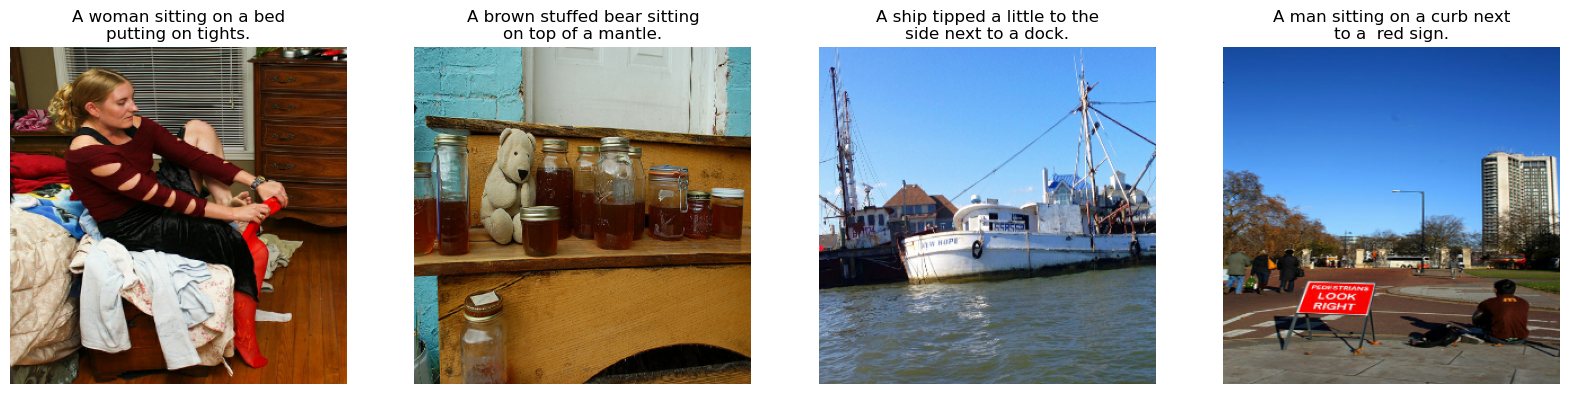

In [4]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

In [5]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

In [6]:
MAX_CAPTION_LEN = 64


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

In [7]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [8]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [9]:
sample_captions

[b'<start> A person wearing a red jacket while standing under a blue sky. <end>',
 b'<start> The dining table is in the middle of the large kitchen. <end>',
 b'<start> A yellow and gray train parked at a train station. <end>',
 b'<start> A bulletin board sitting on top of a wooden wall next to a chair. <end>',
 b'<start> there is a woman walking in the grass holding a umbrella <end>']

In [10]:
print(tokenizer(sample_captions))

tf.Tensor(
[[    3     2    33    86     2    45   398    56    15   119     2    58
    131     4     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    3     7   499    25    11     8     7   222     5     7    29    64
      4     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    3     2   104    10   339    44    68    21     2    44   226     4
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0    

In [11]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a person wearing a red jacket while standing under a blue sky <end>                                                   

In [12]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [13]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [14]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3  20  24  74 130 259   8   7 131   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[ 20  24  74 130 259   8   7 131   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  22 260   2 878   6  23   5   2 273   8   2  64   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

In [15]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [16]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


In [17]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_atention = Attention()
context_vector = decoder_atention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

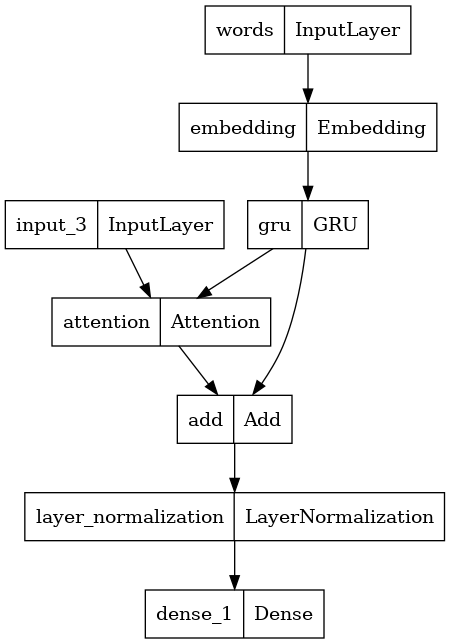

In [18]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [19]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 512)      10240000    ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 64, 512),    1575936     ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

In [20]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [22]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

In [23]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

2586/2586 [==============================] - 974s 363ms/step - loss: 0.5710
CPU times: user 16min 15s, sys: 1min 22s, total: 17min 37s
Wall time: 16min 13s


In [24]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_atention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [25]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result